In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [11]:
# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 50 #tu
#TIME_rnd = np.add.accumulate(np.random.poisson(9,100))
#PE_rnd   = np.random.choice([1,2],100,replace=True,p=[0.95,0.05])
TIME_rnd     = np.array([ 500, 570,1000,1040,1060,1100,1110,1160,1200,1230,1300,
                         1400,1440,1460,1500,1510,1560,1600,1630,1700,1710,1750])
PE_rnd       = np.array([   1,   4,  30,  40,  25,  15,  20,  25,  30,  10,   4,   
                           25,  35,  20,  10,  40,  30,  15,  10,   5,   4,   1])

In [12]:
# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array]:
    
    spe_response,norm = wvf.apply_spe_dist(np.arange(0,20000),[10,500])
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response))
    pe   = np.zeros(pe_time_zs[0,-1]*time_step+len(spe_response))
    pe[pe_time_zs[0,:]*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    wave = wvf.convolve_tof(spe_response,pe)
    return time,wave

In [13]:
time,wave = wave_gen(np.vstack([TIME_rnd,PE_rnd]))

<IPython.core.display.Javascript object>


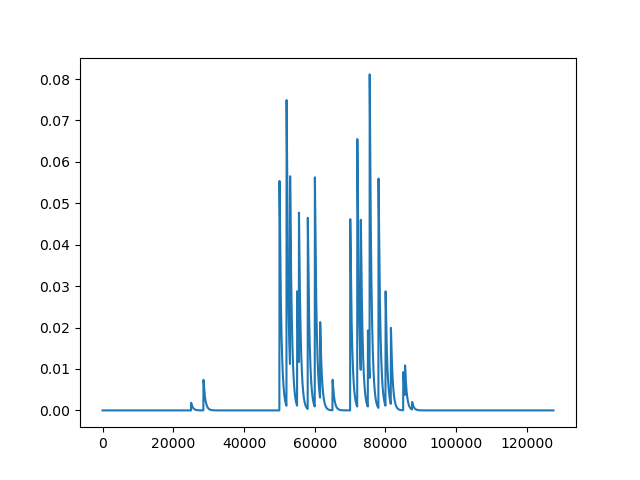

In [14]:
plt.plot(wave)

# Shaping

In [5]:
f_sample = (1/time_unit); # Hz
freq_LPF = 1/(100*1E-9); # rad/sec
freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
# Filter Definitions
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,wave)

<IPython.core.display.Javascript object>


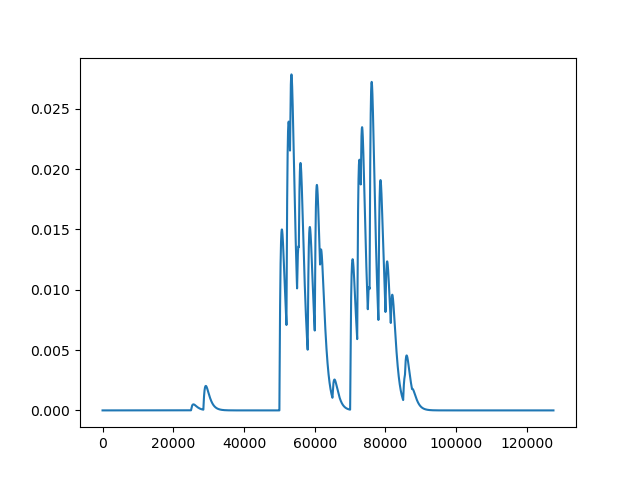

In [6]:
#plt.plot(wave)
plt.plot(signal_out)


# ASIC Algorithm (Time True, means slow but accurate)

In [7]:
class asic_tt(object):
    def __init__(self,wave,**kwargs):
        # TH0=200E-6,TH1A=1,TH1B=10,TH2=10,
        # GI_LOW_itime=10000,GI_HIGH_itime=10000
        
        self.TH0  = kwargs['TH0']
        self.TH1A = kwargs['TH1A']
        self.TH1B = kwargs['TH1B']
        self.TH2  = kwargs['TH2']
        self.GI_LOW_itime = kwargs['GI_LOW_itime']
        self.GI_HIGH_itime = kwargs['GI_HIGH_itime']
        self.discharge = kwargs['Tdischarge']
        
        self.wave = wave.astype('float')
        self.time = 0
        self.end_time = len(self.wave)
        self.flag_TH1A = False
        self.flag_TH1B = False
        self.flag_TH2  = False
        self.out_stream = np.array([]).reshape((0,4))
        print(self.out_stream)
        # Frame Type   -    Timestamp     -   Integration Value 
        # Frame Type: 0 -> GI_LOW < TH1A
        #             1 -> GI_LOW > TH1A & GI_LOW < TH1B
        #             2 -> GI_LOW > TH1B 
        #             3 -> GI_HIGH > TH2 
        #             4 -> GI_HIGH < TH2 
        self.energy = 0
    
    def outbuilder(self,frame_type,integ_value,counter):
        self.out_stream = np.vstack((self.out_stream,
                                    [frame_type, self.time,integ_value,counter]))
        print("Frame type %d with value %f at time %d - integ_window %d \n" % 
                          (frame_type, integ_value, self.time, counter))
        self.time += self.discharge
        
    def GI_HIGH(self):
        gi_high_counter = 0
        self.flag_TH2   = False
        acc_HIGH = 0
        
        while (gi_high_counter < self.GI_HIGH_itime):
            acc_HIGH += self.wave[self.time]
            
            if (acc_HIGH >= self.TH2):
                self.flag_TH2   = True
            else:
                self.flag_TH2   = False
            
            gi_high_counter += 1 
            
            if (self.time < self.end_time-1):
                self.time += 1
            else:
                self.time += 1
                      
                if (self.flag_TH2):
                    self.outbuilder(3,acc_HIGH,gi_high_counter)
                else:
                    self.outbuilder(2,acc_HIGH,gi_high_counter)
                    
                self.energy +=acc_HIGH
                return acc_HIGH
            
        
        if (self.flag_TH2):
            self.outbuilder(3,acc_HIGH,gi_high_counter)
        else:
            self.outbuilder(4,acc_HIGH,gi_high_counter)
        self.energy +=acc_HIGH
        
        return acc_HIGH
    
    
    def GI_LOW(self):
        gi_low_counter = 0
        self.flag_TH1A = False
        self.flag_TH1B = False
        self.flag_TH2  = False
        acc_LOW = 0
        
        while (gi_low_counter < self.GI_LOW_itime):
            acc_LOW += self.wave[self.time]
            
            if ((acc_LOW >= self.TH1A) and (acc_LOW < self.TH1B)):
                self.flag_TH1A = True
                self.flag_TH1B = False
            elif ((acc_LOW >= self.TH1A) and (acc_LOW >= self.TH1B)):
                # Big signal GI_HIGH required
                self.flag_TH1A = False
                self.flag_TH1B = True
                # Send integration result and flush integrator            
                self.time += 1
                #print("GI_LOW_frame_short %e at time %d\n" % (acc_LOW,self.time))
                self.outbuilder(2,acc_LOW,gi_low_counter)
            
                self.energy +=acc_LOW   
                acc_LOW = 0                
                self.GI_HIGH()
                while (self.flag_TH2):
                    self.GI_HIGH()
                self.time -= 1
                gi_low_counter = -1
                # Compensation of next increase
                
            else:
                # Integration below TH1A
                self.flag_TH1A = False
                self.flag_TH1B = False
            
            gi_low_counter += 1    
            if (self.time < self.end_time-1):
                self.time += 1
            else:
                self.time += 1
                
                if (self.flag_TH1A and self.flag_TH1B):
                    self.outbuilder(3,acc_LOW,gi_low_counter)
                elif (self.flag_TH1A and not(self.flag_TH1B)):
                    self.outbuilder(1,acc_LOW,gi_low_counter)
                else:
                    self.outbuilder(0,acc_LOW,gi_low_counter)
                self.energy +=acc_LOW
                return acc_LOW
        
        
        if (self.flag_TH1A and self.flag_TH1B):
            self.outbuilder(3,acc_LOW,gi_low_counter)
        elif (self.flag_TH1A and not(self.flag_TH1B)):
            self.outbuilder(1,acc_LOW,gi_low_counter)
        else:
            self.outbuilder(0,acc_LOW,gi_low_counter)
        
        self.energy +=acc_LOW
        
        return acc_LOW
            
            
    def run_asic_tt(self):
        while (self.time < self.end_time):
            if (self.wave[self.time] > self.TH0):
                print(">TH0 %d" % self.time)
                self.GI_LOW()
                while (self.flag_TH1A):
                    self.GI_LOW()
                self.time -= 1
                
            if (self.time < self.end_time-1):
                self.time += 1
            else:
                print(self.energy)
                print(np.sum(self.wave))
                print("Energy Error %f %%" % (((np.sum(self.wave)-np.sum(self.energy))/np.sum(self.wave))*100))
                return 
        
        
            

In [8]:
A = asic_tt(signal_out, TH0  = 200E-6,
                        TH1A = 2,
                        TH1B = 10,
                        TH2  = 20,
                        GI_LOW_itime  = 10000,
                        GI_HIGH_itime = 10000,
                        Tdischarge    = 15) 

[]


In [9]:
A.run_asic_tt()


>TH0 25130
Frame type 1 with value 4.976498 at time 35130 - integ_window 10000 

Frame type 0 with value 0.010586 at time 45145 - integ_window 10000 

>TH0 50010
Frame type 2 with value 10.003230 at time 50872 - integ_window 861 

Frame type 3 with value 151.962758 at time 60887 - integ_window 10000 

Frame type 3 with value 45.227990 at time 70902 - integ_window 10000 

Frame type 3 with value 152.843593 at time 80917 - integ_window 10000 

Frame type 3 with value 33.009582 at time 90932 - integ_window 10000 

Frame type 4 with value 0.126753 at time 100947 - integ_window 10000 

Frame type 0 with value 0.000006 at time 110962 - integ_window 10000 

398.1609971699362
398.9999999999591
Energy Error 0.210276 %


In [147]:
print(A.out_stream)

[[1.00000000e+00 3.51300000e+04 4.97649775e+00 1.00000000e+04]
 [0.00000000e+00 4.51500000e+04 1.05337134e-02 1.00000000e+04]
 [2.00000000e+00 5.08720000e+04 1.00032304e+01 8.61000000e+02]
 [3.00000000e+00 6.08920000e+04 1.51977510e+02 1.00000000e+04]
 [4.00000000e+00 7.09120000e+04 4.51750675e+01 1.00000000e+04]
 [2.00000000e+00 7.20590000e+04 1.00045837e+01 1.12600000e+03]
 [3.00000000e+00 8.20790000e+04 1.52945109e+02 1.00000000e+04]
 [4.00000000e+00 9.20990000e+04 2.25989271e+01 1.00000000e+04]
 [0.00000000e+00 1.02119000e+05 3.95062922e-02 1.00000000e+04]]
